# Train model to recognize voice of people **Base Dataset Augmented**    

In [1]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from enum import Enum
import pandas as pd
from pathlib import Path
from torchvision.transforms.functional import normalize
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
DATASET_PATH = './dataset/'
DATA_PATH = './data/'
MODEL_SAVE_PATH = './model_save/'

In [35]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform, AddGaussianNoiseWrapperTransform
from src.transform.composite_transformation import CompositeTransformation
SAMPLE_RATE=16000
transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)

In [36]:
from src.dataset.base_dataset import BaseSoundDS


train_df = pd.read_csv(DATASET_PATH + "./train_base_dataset.csv")
train_ds = BaseSoundDS(train_df, DATA_PATH + "validated_16000/", transform=transform)

In [37]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/", transform=transform)

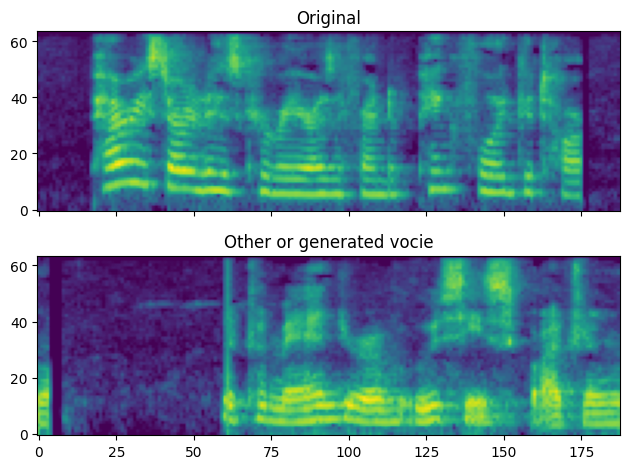

In [38]:
from src.utils.plot import plot

plot(train_ds[789])

In [39]:
class SiameseNetwork(nn.Module):
		def __init__(self):
				super(SiameseNetwork, self).__init__()
				self.conv_layers = nn.Sequential(
						nn.Conv2d(1, 32, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(32, 64, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(64, 128, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
						nn.Conv2d(128, 256, kernel_size=3),
						nn.ReLU(inplace=True),
						nn.MaxPool2d(kernel_size=2, stride=2),
				)
				self.fc_layers = nn.Sequential(
						nn.Linear(4608, 1024),
						nn.ReLU(inplace=True),
				)

				self.final = nn.Linear(1024, 2)

		def forward_once(self, x):

				x = self.conv_layers(x)
				x = x.view(x.size(0), -1)
				x = self.fc_layers(x)
				return x

		def forward(self, input1, input2):
			output1 = self.forward_once(input1)
			output2 = self.forward_once(input2)
			return self.final(torch.abs(output1 - output2))

In [40]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [41]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def evaluate_siamese_model(model, dataloader, criterion, device='cpu'):
	model.eval()
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred) for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)

	return avg_loss, accuracy, precision, recall, f1

In [42]:
def train_siamese_model(model, dataloader, criterion, optimizer, device='cpu'):
	model.train()
	total_loss = 0.0
	predictions = []
	true_labels = []

	for batch in tqdm(dataloader, desc="Training", leave=False):
		anchor_sgram, posneg_sgram, label = batch
		anchor_sgram = anchor_sgram.to(device)
		posneg_sgram = posneg_sgram.to(device)
		label = label.to(device)
		
		optimizer.zero_grad()
		output = model(anchor_sgram, posneg_sgram)
		loss = criterion(output, label)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		predictions += [torch.argmax(pred) for pred in output.cpu()]
		true_labels += [label.item() for label in label.cpu()]

	accuracy = accuracy_score(true_labels, predictions)
	precision = precision_score(true_labels, predictions)
	recall = recall_score(true_labels, predictions)
	f1 = f1_score(true_labels, predictions)

	avg_loss = total_loss / len(dataloader)
	avg_loss = total_loss / len(dataloader)
	
	return avg_loss, accuracy, precision, recall, f1

In [18]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [43]:
num_epochs = 10
siamese_model = SiameseNetwork().to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
loss, accuracy, precision, recall, f1 = [], [], [], [], []
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/10, Loss: 0.6186, Accuracy: 0.6349, Precision: 0.6448, Recall: 0.6007, F1: 0.6220


Epoch 1/10, Loss: 0.5177, Accuracy: 0.7377, Precision: 0.7330, Recall: 0.7478, F1: 0.7403


Epoch 2/10, Loss: 0.5416, Accuracy: 0.7202, Precision: 0.7132, Recall: 0.7365, F1: 0.7247


Epoch 2/10, Loss: 0.5348, Accuracy: 0.7145, Precision: 0.6832, Recall: 0.8000, F1: 0.7370


Epoch 3/10, Loss: 0.4952, Accuracy: 0.7550, Precision: 0.7381, Recall: 0.7904, F1: 0.7634


Epoch 3/10, Loss: 0.5339, Accuracy: 0.7203, Precision: 0.6603, Recall: 0.9072, F1: 0.7643


Epoch 4/10, Loss: 0.4580, Accuracy: 0.7759, Precision: 0.7559, Recall: 0.8148, F1: 0.7843


Epoch 4/10, Loss: 0.5871, Accuracy: 0.7043, Precision: 0.6850, Recall: 0.7565, F1: 0.7190


Epoch 5/10, Loss: 0.4319, Accuracy: 0.8037, Precision: 0.7789, Recall: 0.8483, F1: 0.8121


Epoch 5/10, Loss: 0.4551, Accuracy: 0.7739, Precision: 0.7480, Recall: 0.8261, F1: 0.7851


Epoch 6/10, Loss: 0.4179, Accuracy: 0.8103, Precision: 0.7852, Recall: 0.8543, F1: 0.8183


Epoch 6/10, Loss: 0.5461, Accuracy: 0.7406, Precision: 0.7075, Recall: 0.8203, F1: 0.7597


Epoch 7/10, Loss: 0.3926, Accuracy: 0.8210, Precision: 0.7991, Recall: 0.8577, F1: 0.8274


Epoch 7/10, Loss: 0.5226, Accuracy: 0.7551, Precision: 0.6973, Recall: 0.9014, F1: 0.7863


Epoch 8/10, Loss: 0.3748, Accuracy: 0.8365, Precision: 0.8119, Recall: 0.8758, F1: 0.8427


Epoch 8/10, Loss: 0.4662, Accuracy: 0.7884, Precision: 0.7409, Recall: 0.8870, F1: 0.8074


Epoch 9/10, Loss: 0.3732, Accuracy: 0.8295, Precision: 0.8090, Recall: 0.8626, F1: 0.8350


Epoch 9/10, Loss: 0.4745, Accuracy: 0.7841, Precision: 0.7438, Recall: 0.8667, F1: 0.8005


Epoch 10/10, Loss: 0.3517, Accuracy: 0.8478, Precision: 0.8258, Recall: 0.8814, F1: 0.8527


Epoch 10/10, Loss: 0.4476, Accuracy: 0.8101, Precision: 0.7846, Recall: 0.8551, F1: 0.8183


In [45]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")
	plt.tight_layout()
	plt.show()

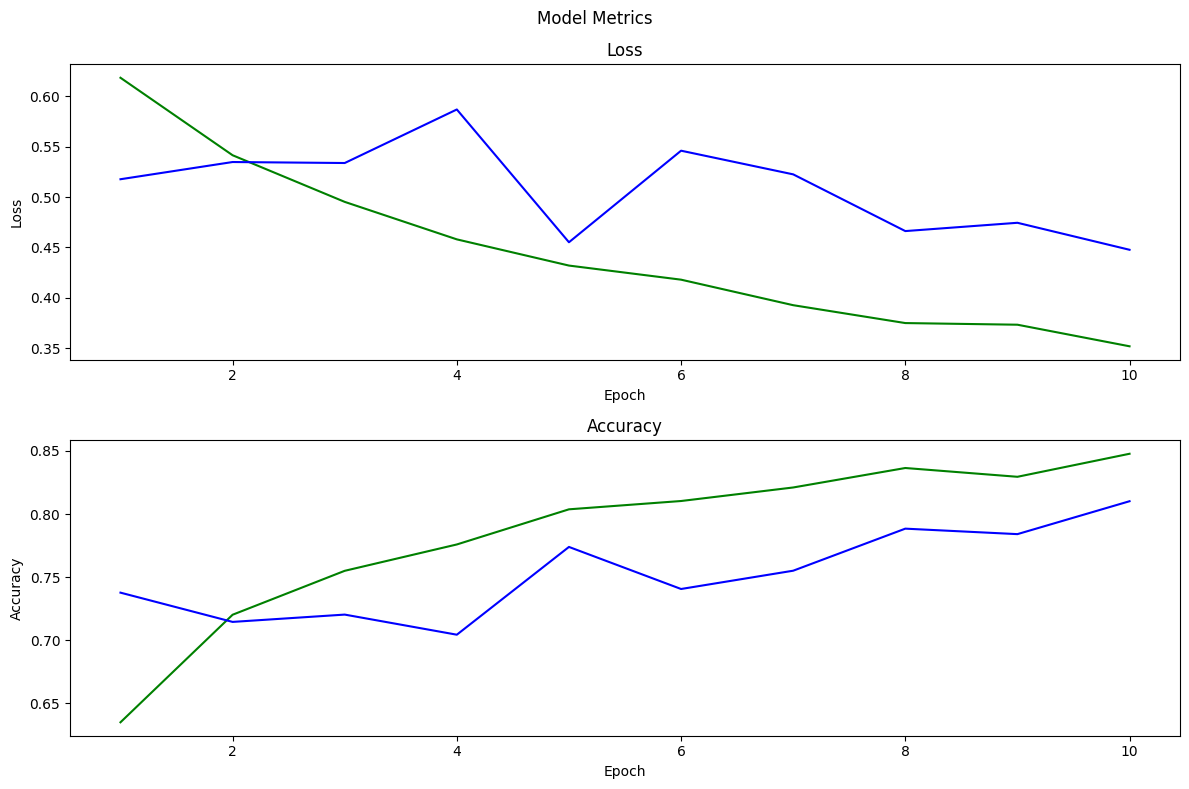

In [46]:
plot_metrix(loss, accuracy)

In [47]:
def save_model(model, model_name, base_path = './model_save/'):
	model.cpu()
	model.eval()
	torch.save(model, base_path + model_name)

In [81]:
save_model(siamese_model, "base_cnn.pt")

In [48]:
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad[0]), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad[0]), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad

In [49]:

def plot_explain_siamese_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.figure(figsize=(10, 2))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
				 origin="lower", aspect="auto")
	plt.show()

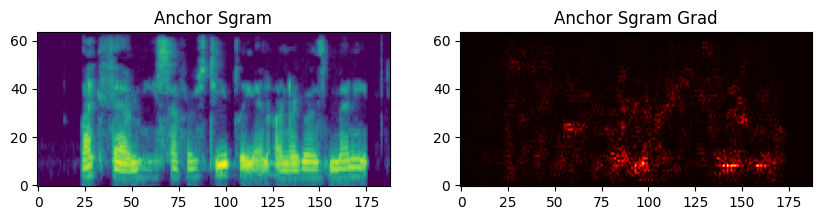

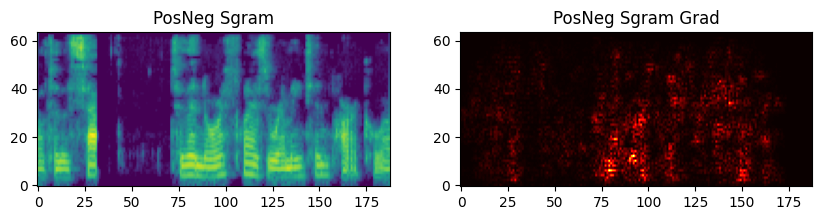

In [50]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = test_ds[4]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

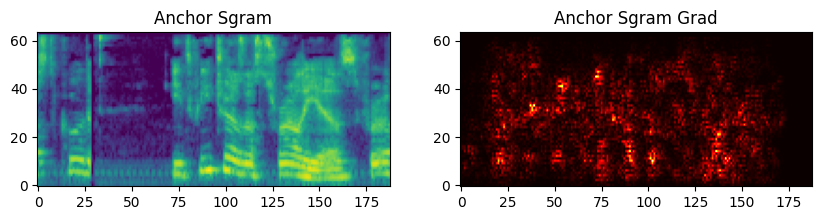

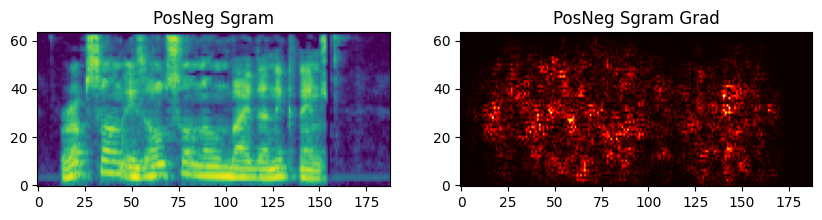

In [51]:
from src.utils.plot import plot_explain_siamese_model_all

anchor_sgram, posneg_sgram, _ = train_ds[0]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_model_all(anchor_sgram[0], posneg_sgram[0], anchor_sgram_grad, posneg_sgram_grad)

In [52]:
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [53]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "other","same"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()


In [54]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

accuracy: 0.7855072463768116


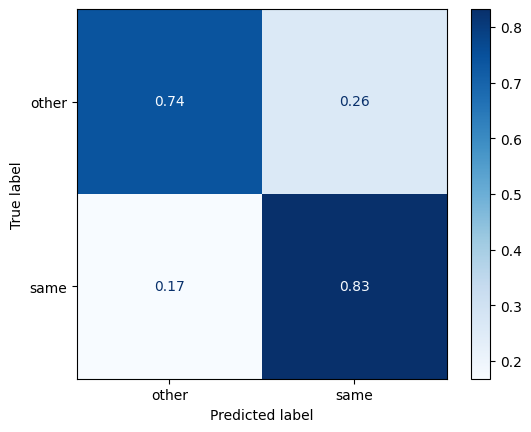

In [55]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

accuracy: 0.9173880316146029


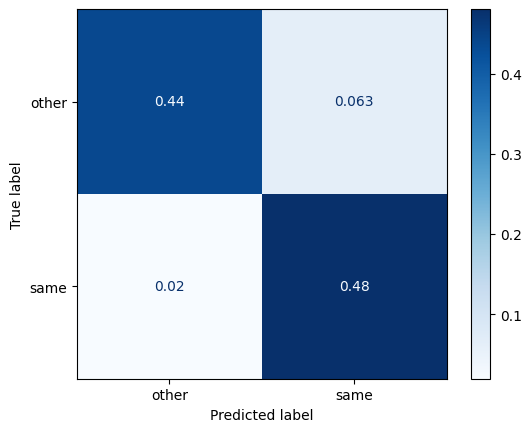

In [182]:
avg_loss, true_labels, predictions = test(siamese_model, train_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [56]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset.csv")
test_ds = GeneratedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


accuracy: 0.6057971014492753


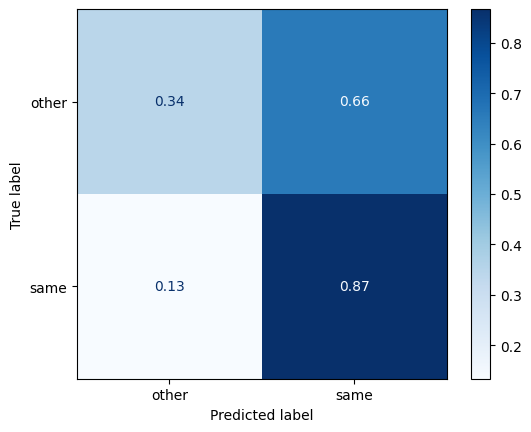

In [57]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [196]:
from src.dataset.combined_dataset import CombinedSoundDS
import librosa

from src.columns.combined_dataset_column import CombinedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
                    ToMelSpectrogramTransform(
                        sample_rate=sample_rate, n_mels=64, n_fft=512)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        spectrogram = spectrogram.unsqueeze(0)
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6777163904235728


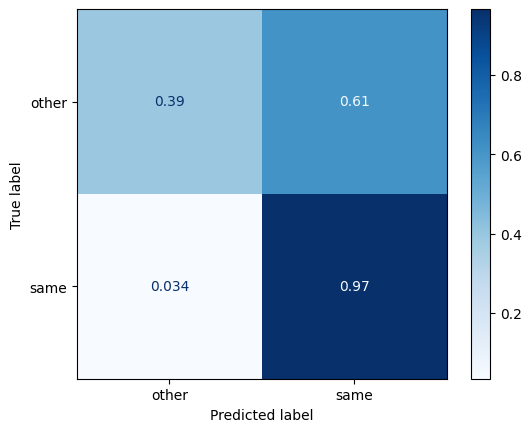

In [198]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [58]:
SAMPLE_RATE = 16000

In [61]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3, padding_direction="start"),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
    #AddGaussianNoiseWrapperTransform(min_amplitude=0.001, max_amplitude=0.005),
		ToMelSpectrogramTransform(sample_rate=SAMPLE_RATE, n_mels=64, n_fft=512)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/",  transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.7956521739130434


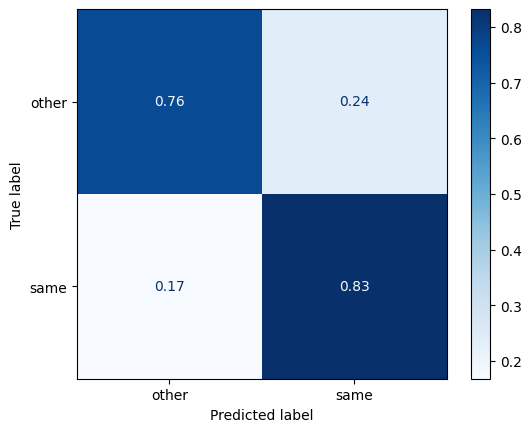

In [63]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)